### Dependencies

In [1]:
!pip install matplotlib tensorflow tensorflow_addons tensorflow_datasets imageio

### Setup

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.keras import Model
import tensorflow as tf
import tensorflow_addons as tfa

from IPython import display

### Dataset

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
#   "/home/tony/TO_BE_REMOVED/celeba_data/imgs/",
  "/Users/anthonylaw/Desktop/Endless/GAN-devel/mnist_ds/mnist_jpg/training",
  seed=123,
  image_size=(32, 32),
  batch_size=16)

Found 60000 files belonging to 10 classes.


2022-09-01 11:21:53.160388: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# for i_b, l_b in train_ds:
#     print(i_b.shape)
#     print(tf.image.rgb_to_grayscale(i_b).shape)

#### Note: 

Images should be normalized to [-1,1] ***(Done in Arch)***

### Generator network

#### Note:

Modify the network size for deployment

In [21]:
class Generator(Model):

    def __init__(self, noise_dim, image_shape, num_channel):
        super().__init__()
        
        assert len(image_shape) == 2
        assert image_shape[0]%8 == 0
        assert image_shape[1]%8 == 0
        
        self.noise_dim = noise_dim
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.kernel_size = int(min(max(min(image_shape[0]/8.0-3.0, image_shape[1]/8.0-3.0), 3.0), 5.0))

        self.lr_d = layers.ReLU()
        self.lr_c1 = layers.ReLU()
        self.lr_c2 = layers.ReLU()
        self.lr_c3 = layers.ReLU()
        
        self.init_dense = layers.Dense(image_shape[0]/8.0*image_shape[1]/8.0*64,
                               use_bias=False, input_shape=(self.noise_dim,))
        
        self.init_reshape = layers.Reshape((int(image_shape[0]/8.0), int(image_shape[1]/8.0), 64))
        
        self.conv2dT1 = layers.Conv2DTranspose(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        self.conv2dT2 = layers.Conv2DTranspose(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.conv2dT3 = layers.Conv2DTranspose(16, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.conv2dTactv = layers.Conv2DTranspose(self.num_channel, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same', activation='tanh')

    def call(self, noise_vec):

        init_vec = tf.squeeze(self.lr_d(self.init_dense(noise_vec)))
        
#         print(init_vec.shape)
        
        reshaped = self.init_reshape(init_vec)
        
#         print(reshaped.shape)
        
        convt1 = self.lr_c1(self.conv2dT1(reshaped))

#         print(convt1.shape)
        
        convt2 = self.lr_c2(self.conv2dT2(convt1))
        
#         print(convt2.shape)
                         
        convt3 = self.lr_c3(self.conv2dT3(convt2))
        
#         print(convt3.shape)
            
        out = self.conv2dTactv(convt3)
        
#         print(out.shape)

        return out

#### Testing

In [22]:
g1 = Generator(10, (32, 32), 3)

In [23]:
g1.kernel_size

3

In [24]:
noise_input = tf.random.normal((5, 10))
print(noise_input.shape)
pics1 = g1(tf.expand_dims(noise_input, 0))
print(pics1.shape)
# plt.imshow(pics1[-1, :, :, :], cmap='gray')

(5, 10)
(5, 32, 32, 3)


In [25]:
g1.summary()

Model: "generator_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 re_lu_12 (ReLU)             multiple                  0         
                                                                 
 re_lu_13 (ReLU)             multiple                  0         
                                                                 
 re_lu_14 (ReLU)             multiple                  0         
                                                                 
 re_lu_15 (ReLU)             multiple                  0         
                                                                 
 dense_5 (Dense)             multiple                  10240     
                                                                 
 reshape_3 (Reshape)         multiple                  0         
                                                                 
 conv2d_transpose_12 (Conv2D  multiple                 

### Discriminator

In [26]:
class Discriminator(Model):

    def __init__(self, image_shape, num_channel):
        super().__init__()
        
        assert len(image_shape) == 2
        assert image_shape[0]%8 == 0
        assert image_shape[1]%8 == 0
        
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.kernel_size = int(min(max(min(image_shape[0]/8.0-3.0, image_shape[1]/8.0-3.0), 3.0), 5.0))

        self.lr_c1 = layers.LeakyReLU()
        self.lr_c2 = layers.LeakyReLU()
        self.lr_c3 = layers.LeakyReLU()
        self.flatten = layers.Flatten()
        
        self.conv2d1 = layers.Conv2D(16, (self.kernel_size, self.kernel_size),
                                        strides=(2, 2), padding='same',
                                        input_shape=(None, self.image_shape[0],
                                        self.image_shape[1], self.num_channel))
        self.conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.conv2d3 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        self.dense_actv = layers.Dense(64,
                                      )
#                                        activation="sigmoid")
        
    def call(self, img_input):
        
        conv1 = self.lr_c1(self.conv2d1(img_input))
        
#         print(conv1.shape)
        
        conv2 = self.lr_c2(self.conv2d2(conv1))
        
#         print(conv2.shape)
                         
        conv3 = self.lr_c3(self.conv2d3(conv2))
        
#         print(conv3.shape)
        
        flat = self.flatten(conv3)
        
#         print(flat.shape)
        
        out = tf.squeeze(self.dense_actv(flat))
        
#         print(out.shape)

        return out

#### Testing

In [27]:
d1 = Discriminator((32,32), 3)
g2 = Generator(10, (32,32), 3)
d1.kernel_size

3

In [28]:
noise_input = tf.random.normal((5, 10))
pics2 = g1(tf.expand_dims(noise_input, 0))
# plt.imshow(pics2[-1, :, :, 0], cmap='gray')
print(pics2.shape)

(5, 32, 32, 3)


In [29]:
deci = d1(pics2)
deci

<tf.Tensor: shape=(5, 64), dtype=float32, numpy=
array([[ 4.6570913e-04, -3.7977495e-04,  6.4406497e-04, -1.7448349e-04,
        -1.2984733e-03,  1.0737083e-03,  1.8655992e-03, -1.4300996e-03,
         1.4047219e-03, -6.3897215e-04, -2.2435079e-03,  7.2772673e-07,
        -1.7182576e-03,  7.7286165e-04,  5.1403284e-04,  1.7375278e-04,
        -2.8508069e-04,  3.9117064e-04, -7.2702736e-04, -3.4242187e-04,
         7.6254056e-04, -2.4159767e-03,  6.8850443e-04, -7.2973687e-04,
         1.8123839e-03,  5.8362260e-04,  9.9376997e-04,  7.2571693e-04,
        -3.8233091e-04, -1.5903246e-03,  2.2297180e-03, -1.7364428e-03,
         6.5300090e-05, -1.0395742e-03,  1.4088976e-03, -3.1928491e-04,
        -4.9555319e-04,  2.7451006e-04,  1.2493773e-03, -2.7307961e-04,
        -7.4445340e-04,  1.6105545e-03,  1.9071408e-03, -1.1294180e-03,
         2.8986135e-05, -8.7318505e-04,  6.5147702e-04, -1.8481551e-03,
         4.0072046e-05,  1.2583821e-03,  8.4284623e-04,  5.6105398e-04,
         1.0716

In [30]:
d1.summary()

Model: "discriminator_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 leaky_re_lu_6 (LeakyReLU)   multiple                  0         
                                                                 
 leaky_re_lu_7 (LeakyReLU)   multiple                  0         
                                                                 
 leaky_re_lu_8 (LeakyReLU)   multiple                  0         
                                                                 
 flatten_2 (Flatten)         multiple                  0         
                                                                 
 conv2d_6 (Conv2D)           multiple                  448       
                                                                 
 conv2d_7 (Conv2D)           multiple                  4640      
                                                                 
 conv2d_8 (Conv2D)           multiple              

### CramerDCGAN

In [46]:
EPSILON = 1e-16

class DCGAN:
    
    def __init__(self, dataset_path, image_shape, num_channel, noise_latent_dim, disc_update_multi=5, 
                 batch_size=128, lr=3e-4, gp_lam = 10.0, div_lam = 1.0):
        assert len(image_shape) == 2
        assert image_shape[0]%8 == 0
        assert image_shape[1]%8 == 0
        
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.noise_latent_dim = noise_latent_dim
        self.batch_size, self.gp_lam = batch_size, gp_lam
        self.disc_update_multi = disc_update_multi
        self.num_img_prog_monit = 16
        self.div_lam = div_lam
        
        if not dataset_path==None:
            self.dataset = tf.keras.utils.image_dataset_from_directory(
                                  dataset_path,
                                  seed=123,
                                  image_size=self.image_shape,
                                  batch_size=self.batch_size)
        else:
            print("WARNING: Dataset not loaded, Model in Generator mode")
        # NOTE: Dataset must be processed differently for different source and applications
        
        self.g = Generator(self.noise_latent_dim, self.image_shape, self.num_channel)
        self.d = Discriminator(self.image_shape, self.num_channel)
        
        self.g_opt = tf.keras.optimizers.Adam(lr)
        self.d_opt = tf.keras.optimizers.Adam(lr)
        
        self.g_seed = tf.random.normal((self.num_img_prog_monit, self.noise_latent_dim))

    def cramer_loss(self, d_x_data, d_g_z_1, d_g_z_2, x_it):
        
        with tf.GradientTape() as t_gp:
            t_gp.watch(x_it)
            d_it = self.d(x_it)
            crit_it = tf.math.add(tf.math.sqrt(tf.reduce_sum(tf.math.add(d_it, -d_g_z_2)**2, axis = 1)+EPSILON),
                   -tf.math.sqrt(tf.reduce_sum(tf.math.add(d_it, -d_x_data)**2, axis = 1)+EPSILON))
            
        gp_grad = t_gp.gradient(crit_it, x_it)
        l2n_gp = tf.math.sqrt(tf.reduce_sum(gp_grad**2, axis = [1,2,3])+EPSILON)
        L_gp = self.gp_lam*((l2n_gp-1.0)**2)


        l2nrg1 = tf.math.sqrt(tf.reduce_sum(tf.math.add(d_x_data, -d_g_z_1)**2, axis = 1)+EPSILON)
        l2nrg2 = tf.math.sqrt(tf.reduce_sum(tf.math.add(d_x_data, -d_g_z_2)**2, axis = 1)+EPSILON)
        l2ng12 = tf.math.sqrt(tf.reduce_sum(tf.math.add(d_g_z_1, -d_g_z_2)**2, axis = 1)+EPSILON)

        # g_loss
        L_g = tf.reduce_mean(l2nrg1 + l2nrg2 - l2ng12)
        
        # d_loss
        L_d = tf.reduce_mean(-(l2nrg1 + l2nrg2 - l2ng12) + (self.gp_lam*((l2n_gp-1.0)**2)))

        return L_g, L_d
    
    def div_loss(self, g_z1, g_z2):

    L_div = tf.math.sqrt(tf.reduce_sum(tf.math.add(g_z1, -g_z2)**2, axis = [1,2,3])+EPSILON)

    return tf.reduce_mean(L_div)
    
    @tf.function
    def update(self, imgs, update_gen=True):
        noise_input1 = tf.random.normal((imgs.shape[0], self.noise_latent_dim))
        noise_input2 = tf.random.normal((imgs.shape[0], self.noise_latent_dim))
        
        with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
            g_z_1 = self.g(noise_input1)
            g_z_2 = self.g(noise_input2)
            
            d_x_data = self.d(imgs)
            d_g_z_1 = self.d(g_z_1)
            d_g_z_2 = self.d(g_z_2)
            
            epsi = tf.random.uniform([imgs.shape[0], 1, 1, 1], 0.0, 1.0)
            x_it = tf.math.add(epsi*imgs, (1.0-epsi)*g_z_1)
            g_loss, d_loss = self.cramer_loss(d_x_data, d_g_z_1, d_g_z_2, x_it)
            div_loss = self.div_loss(g_z_1, g_z_2)
            
            g_loss = g_loss-self.div_lam*div_loss

        if update_gen:
            grad_g = g_tape.gradient(g_loss, self.g.trainable_variables)
            grad_d = d_tape.gradient(d_loss, self.d.trainable_variables)

            self.g_opt.apply_gradients(zip(grad_g, self.g.trainable_variables))
            self.d_opt.apply_gradients(zip(grad_d, self.d.trainable_variables))
        else:
            grad_d = d_tape.gradient(d_loss, self.d.trainable_variables)
            self.d_opt.apply_gradients(zip(grad_d, self.d.trainable_variables))
            
        return g_loss, d_loss
        
    def train(self, epochs=250, train_moni_path=None):
        num_training = 0
        for epo in range(epochs):
            g_losses = []
            d_losses = []
            for img_b, l_b in self.dataset:
                if self.num_channel == 1 and img_b.shape[-1] == 3:
                    img_b = tf.image.rgb_to_grayscale(img_b)
                norm_img_b = (img_b-127.5)/127.5
                if num_training%self.disc_update_multi == 0:
                    g_l, d_l = self.update(norm_img_b, True)
                    g_losses.append(g_l.numpy())
                    d_losses.append(d_l.numpy())
                    
                else:
                    g_l, d_l = self.update(norm_img_b, False)
                    d_losses.append(d_l.numpy())
                    
                num_training = (num_training+1)%self.disc_update_multi
                
            print("Epoch {:04d}".format(epo), "Generator Avg. Loss: ", np.mean(g_losses), 
                  ", Discriminator Avg. Loss: ",  np.mean(d_losses), flush=True)
                
            if not train_moni_path == None:
                self.monitor_progress(epo, train_moni_path)
            
    def monitor_progress(self, epo, path):
        pics = self.g(self.g_seed)
        
        fig = plt.figure(figsize=(4,4))
        for i in range(pics.shape[0]):
            plt.subplot(4,4,i+1)
            if self.num_channel == 1:
                plt.imshow(pics[i,:,:,0], cmap='gray')
            else:   
                plt.imshow(tf.cast(tf.math.round(pics[i,:,:,:]*127.5+127.5), tf.int32))
            plt.axis('off')
            
        plt.savefig(path+'/image_{:04d}.png'.format(epo))
#         plt.savefig('/home/tony/TO_BE_REMOVED/imgs/image_{:04d}.png'.format(epo))
        # NEEDS to be changed for machines
        
        plt.close('all')
        
    def save_weights(self, g_path, d_path):
        self.g.save_weights(g_path)
        print("Saved generator weights", flush=True)
        self.d.save_weights(d_path)
        print("Saved discriminator weights", flush=True)
    def load_weights(self, g_path, d_path):
        try:
            self.g.load_weights(g_path).expect_partial()
            print("Loaded generator weights", flush=True)
            self.d.load_weights(d_path).expect_partial()
            print("Loaded discriminator weights", flush=True)
        except ValueError:
            print("ERROR: Please make sure weights are saved as .ckpt", flush=True)
    
    def generate_samples(self, num_sam, path):
        sam_seed = tf.random.normal((num_sam, self.noise_latent_dim))
        sam_pics = self.g(sam_seed)
        for i in range(sam_pics.shape[0]):
            if self.num_channel == 1:
                plt.imshow(sam_pics[i,:,:,0], cmap='gray')
            else:   
                plt.imshow(tf.cast(tf.math.round(sam_pics[i,:,:,:]*127.5+127.5), tf.int32))
            plt.axis('off')
            plt.savefig(path+'/image_{:04d}.png'.format(i))
            plt.close('all')
            

#### Testing

In [47]:
ds_path = "/Users/anthonylaw/Desktop/Endless/GAN-devel/mnist_ds/mnist_jpg/training"

In [48]:
dcgan1 = DCGAN(ds_path, (32, 32), 1, 25, disc_update_multi=1)

Found 60000 files belonging to 10 classes.


In [49]:
dcgan1.train(1,'./imgs')
dcgan1.save_weights('./weights/g_test.ckpt', './weights/d_test.ckpt')

Epoch 0000 Generator Avg. Loss:  18.71285 , Discriminator Avg. Loss:  -13.069563
Saved generator weights
Saved discriminator weights


In [50]:
dcgan1.load_weights('./weights/g_test.ckpt', './weights/d_test.ckpt')

Loaded generator weights
Loaded discriminator weights


In [51]:
dcgan1.generate_samples(10, './samples/0')

In [52]:
dcgan2 = DCGAN(ds_path, (32, 32), 1, 25, disc_update_multi=1)

Found 60000 files belonging to 10 classes.


In [53]:
dcgan2.load_weights('./weights/g_test.ckpt', './weights/d_test.ckpt')

Loaded generator weights
Loaded discriminator weights


In [54]:
dcgan2.train(1, './imgs')

Epoch 0000 Generator Avg. Loss:  17.505833 , Discriminator Avg. Loss:  -10.993472


In [55]:
dcgan2.save_weights('./weights/g_test.ckpt', './weights/d_test.ckpt')

Saved generator weights
Saved discriminator weights


In [56]:
dcgan1.load_weights('./weights/g_test.ckpt', './weights/d_test.ckpt')

Loaded generator weights
Loaded discriminator weights


In [58]:
dcgan3 = DCGAN(None, (32, 32), 1, 25, disc_update_multi=1)

In [60]:
dcgan3.load_weights('./weights/g_test.ckpt', './weights/d_test.ckpt')

Loaded generator weights
Loaded discriminator weights


In [61]:
dcgan3.generate_samples(10, './samples/1')

### Pre-Act Resblk Generator

In [28]:
class Generator(Model):

    def __init__(self, noise_dim, image_shape, num_channel):
        super().__init__()
        
        assert len(image_shape) == 2
        assert image_shape[0]%4 == 0
        assert image_shape[1]%4 == 0
        
        self.noise_dim = noise_dim
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.kernel_size = 3
        
        # add layer(multiple for plot clarification)
        self.add1 = layers.Add()
        self.add2 = layers.Add()
        
        # init layers
        self.init_dense = layers.Dense(image_shape[0]/4.0*image_shape[1]/4.0*64,
                               use_bias=False, input_shape=(None, self.noise_dim), activation='relu')
        
        self.init_reshape = layers.Reshape((int(image_shape[0]/4.0), int(image_shape[1]/4.0), 64))
        
        # in conv 1x1
        self.in_conv11 = layers.Conv2D(64, (1, 1),
                                strides=(1, 1), padding='same')
        
        # resblk 1
        self.rb1_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb1_rl1 = layers.ReLU()
        self.rb1_conv2d1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb1_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb1_rl2 = layers.ReLU()
        self.rb1_conv2d2 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # upsample 1
        self.us1 = layers.Conv2DTranspose(32, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # resblk2
        self.rb2_in1 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb2_rl1 = layers.ReLU()
        self.rb2_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb2_in2 = tfa.layers.InstanceNormalization(axis=-1)
        self.rb2_rl2 = layers.ReLU()
        self.rb2_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # upsample 2
        self.us2 = layers.Conv2DTranspose(16, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # out conv 1x1
        self.out_conv11 = layers.Conv2D(self.num_channel, (1, 1),
                                        strides=(1, 1), padding='same', activation='tanh')

    def call(self, noise_vec):
        
        # in
        x = self.init_reshape(self.init_dense(noise_vec))
        
        # conv 1x1
        x = self.in_conv11(x)
        
        # resblk 1
        x_res = self.rb1_conv2d1(self.rb1_rl1(self.rb1_in1(x)))
        x_res = self.rb1_conv2d2(self.rb1_rl2(self.rb1_in2(x_res)))
        x = self.add1([x, x_res])
        
        # upsample 1
        x = self.us1(x)
        
        # resblk 2
        x_res = self.rb2_conv2d1(self.rb2_rl1(self.rb2_in1(x)))
        x_res = self.rb2_conv2d2(self.rb2_rl2(self.rb2_in2(x_res)))
        x = self.add2([x, x_res])
        
        # upsample 2
        x = self.us2(x)
        
        # conv 1x1
        x = self.out_conv11(x)
        
        return x

    def build_graph(self):
        x = layers.Input(shape=(self.noise_dim,))
        
        return Model(inputs=x, outputs=self.call(x))
        

#### Testing

In [24]:
g1 = Generator(10, (32, 32), 3)

In [25]:
noise_input = tf.random.normal((5, 10))

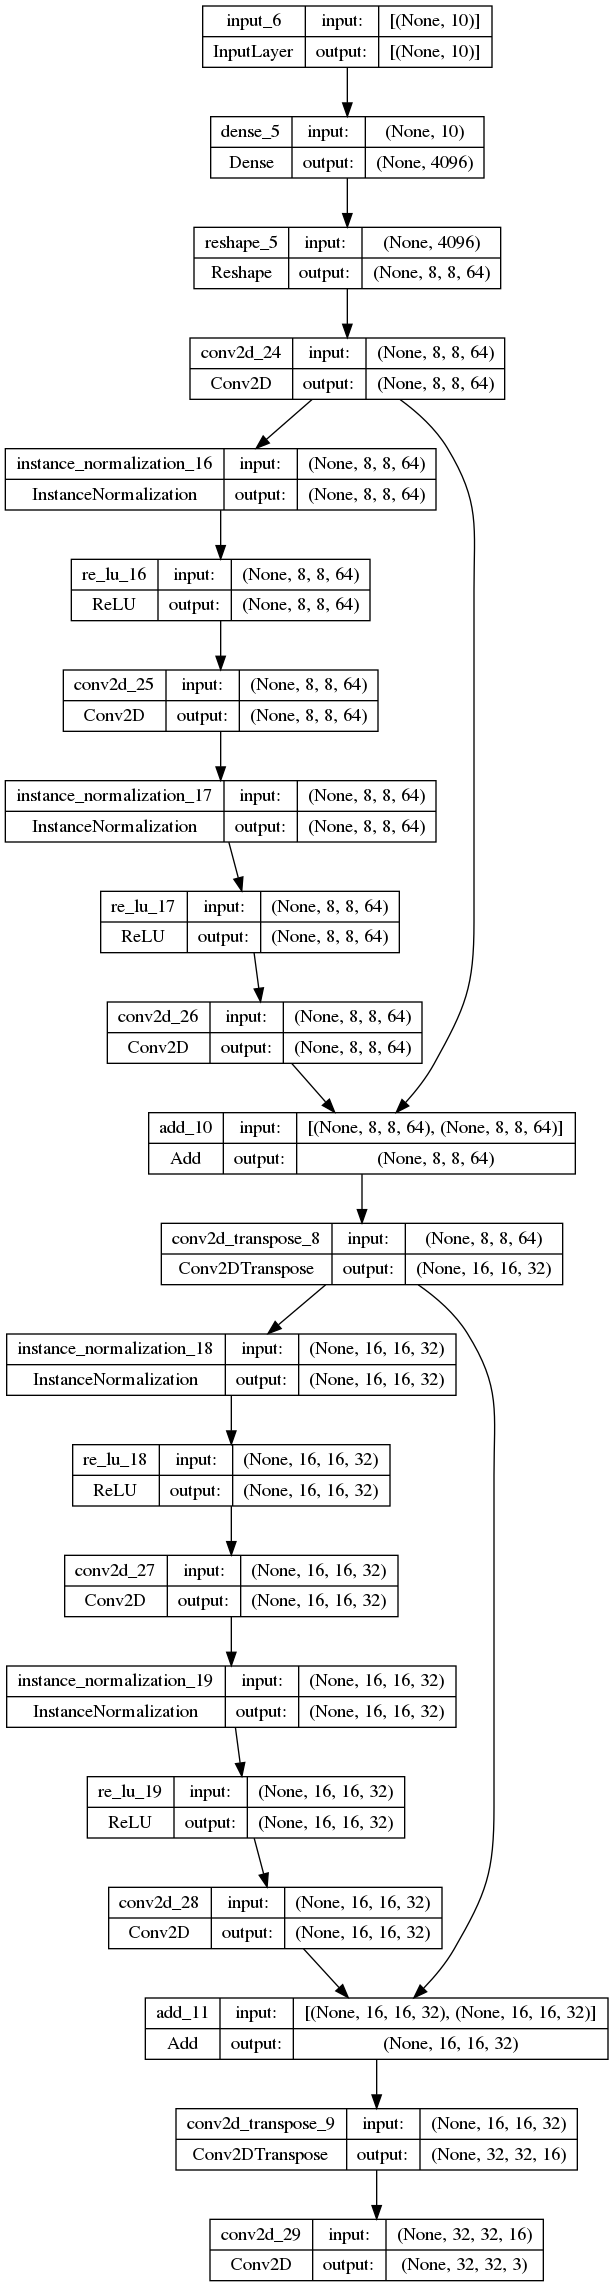

In [26]:
tf.keras.utils.plot_model(g1.build_graph(), show_shapes=True)

In [27]:
g1.build_graph().summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 10)]         0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 4096)         40960       ['input_7[0][0]']                
                                                                                                  
 reshape_5 (Reshape)            (None, 8, 8, 64)     0           ['dense_5[1][0]']                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 8, 8, 64)     4160        ['reshape_5[1][0]']              
                                                                                            

### Pre-Act Resblk Discriminator

In [38]:
class Discriminator(Model):

    def __init__(self, image_shape, num_channel, num_out_filter=64):
        super().__init__()
        
        assert len(image_shape) == 2
        
        self.image_shape = image_shape
        self.num_channel = num_channel
        self.kernel_size = 3
        
        # add layer(multiple for plot clarification)
        self.add1 = layers.Add()
        self.add2 = layers.Add()
        
        
        # in conv 1x1
        self.in_conv11 = layers.Conv2D(32, (1, 1),
                                        strides=(1, 1), padding='same',
                                        input_shape=(None, self.image_shape[0],
                                        self.image_shape[1], self.num_channel))
        
        # resblk 1 
        self.rb1_rl1 = layers.LeakyReLU()
        self.rb1_conv2d1 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb1_rl2 = layers.LeakyReLU()
        self.rb1_conv2d2 = layers.Conv2D(32, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 1
        self.ds1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # resblk 2
        self.rb2_rl1 = layers.LeakyReLU()
        self.rb2_conv2d1 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        self.rb2_rl2 = layers.LeakyReLU()
        self.rb2_conv2d2 = layers.Conv2D(64, (self.kernel_size, self.kernel_size),
                                               strides=(1, 1), padding='same')
        
        # downsample 2
        self.ds2 = layers.Conv2D(128, (self.kernel_size, self.kernel_size),
                                               strides=(2, 2), padding='same')
        
        # reshape for linear act
        self.rs_out = layers.Reshape((int(self.image_shape[0]/4.0)*int(self.image_shape[0]/4.0)*128,))
        
        # out
        self.dense_actv = layers.Dense(num_out_filter,
                                      )

        
        
    def call(self, img_input):
        # in
        x = self.in_conv11(img_input)
        
        # resblk 1
        x_res = self.rb1_conv2d1(self.rb1_rl1(x))
        x_res = self.rb1_conv2d2(self.rb1_rl2(x_res))
        x = self.add1([x, x_res])
        
        # resblk 1 downsample
        x = self.ds1(x)
        
        # resblk 2
        x_res = self.rb2_conv2d1(self.rb2_rl1(x))
        x_res = self.rb2_conv2d2(self.rb2_rl2(x_res))
        x = self.add2([x, x_res])
        
        # resblk 2 downsample
        x = self.ds2(x)
        
        # reshape
        x = self.rs_out(x)
        
        # out
        x = self.dense_actv(x)

        return x
    
    def build_graph(self):
        x = layers.Input(shape=(self.image_shape[0],
                                        self.image_shape[1], self.num_channel))
        
        return Model(inputs=x, outputs=self.call(x))
        

In [39]:
d1 = Discriminator((32, 32), 3)

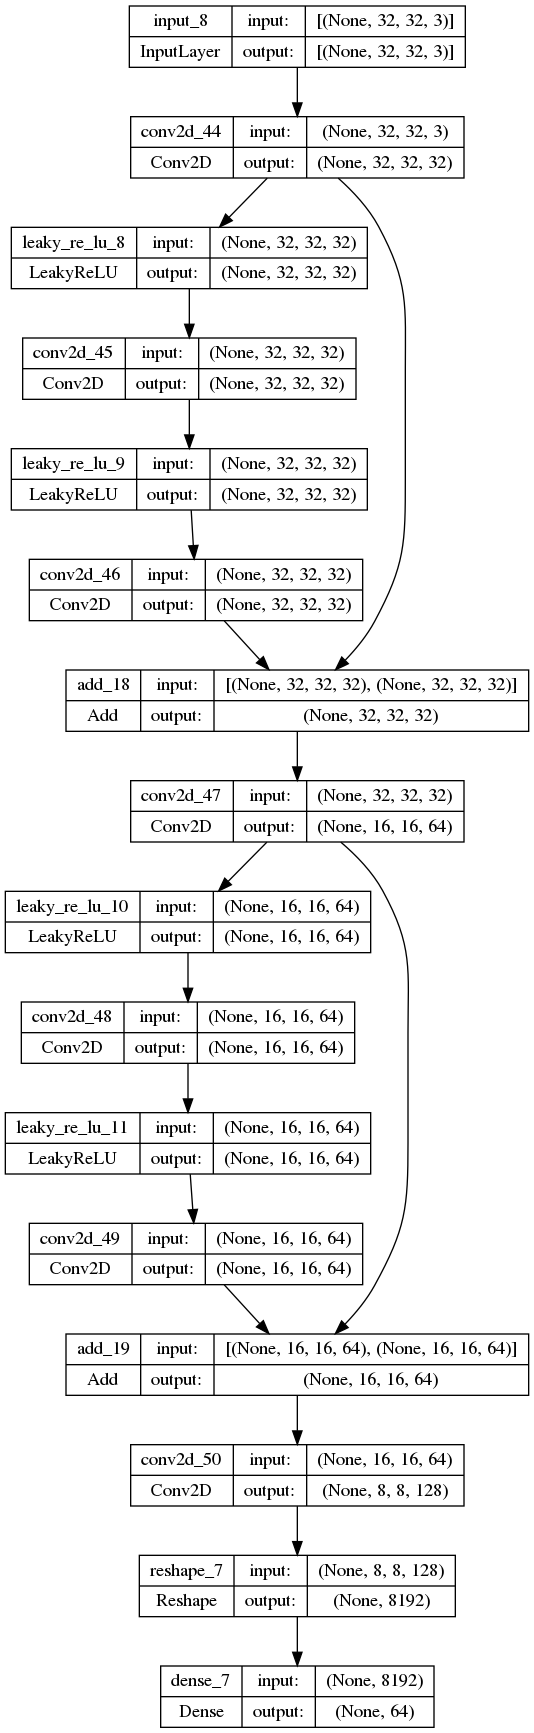

In [40]:
tf.keras.utils.plot_model(d1.build_graph(), show_shapes=True)

In [41]:
d1.build_graph().summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_44 (Conv2D)             (None, 32, 32, 32)   128         ['input_9[0][0]']                
                                                                                                  
 leaky_re_lu_8 (LeakyReLU)      (None, 32, 32, 32)   0           ['conv2d_44[1][0]']              
                                                                                                  
 conv2d_45 (Conv2D)             (None, 32, 32, 32)   9248        ['leaky_re_lu_8[1][0]']          
                                                                                            